In [1]:
using Pkg
using Conda
using WebIO
using Interact
using DifferentialEquations
using DiffEqFlux
using DiffEqSensitivity, OrdinaryDiffEq, Zygote
using Plots
using Flux, Optim, Test
using Optimization, OptimizationPolyalgorithms

WebIO._IJuliaInit()

┌ Warning: OrcV2 initialization failed with
│   err = ErrorException("could not load library \"C:\\Users\\周天恒\\.julia\\artifacts\\12030a5c187a7e327b57d45e3397edf672ab442d\\bin\\libLLVMExtra-12.dll\"\nThe specified procedure could not be found. ")
└ @ Enzyme.Compiler.JIT C:\Users\周天恒\.julia\packages\Enzyme\di3zM\src\compiler\orcv2.jl:103


In [2]:
using BifurcationKit
using Revise
using SparseArrays, LinearAlgebra, DiffEqOperators, Setfield, Parameters
using GaussianProcesses
using Distributions,Random
using ForwardDiff
using MAT
using CSV
using DataFrames

In [3]:
using DataDrivenDiffEq
using ModelingToolkit
using Surrogates,SurrogatesAbstractGPs
using ReservoirComputing

┌ Info: DataDrivenDiffEq : OccamNet is available.
└ @ DataDrivenDiffEq C:\Users\周天恒\.julia\packages\DataDrivenDiffEq\s9jl3\src\DataDrivenDiffEq.jl:168


In [4]:
gr()

Plots.GRBackend()

## True Assumption:
$$
\ddot{x}+b\dot{x}+w_{n}^{2}x+\mu x^3+vx^5+\rho x^7=\delta _{st}w_{n}^{2}\cos \left( wt \right) 
$$

$$
\left\{ \begin{array}{l}
	\dot{x}=y\\
	\dot{y}=-by-w_{n}^{2}x-\mu x^3-vx^5-\rho x^7+\delta _{st}w_{n}^{2}\cos \left( wt \right)\\
\end{array} \right. 
$$


## Eliminate Time Variant
$$
\left\{ \begin{array}{l}
	\dot{x}=y\\
	\dot{y}=-by-\omega _{n}^{2}x-\mu x^3-vx^5-\rho x^7+\delta _{st}\omega _{n}^{2}\mu _1\\
	\dot{\mu}_1=\mu _1+\omega \mu _2-\mu _1\left( \mu _{1}^{2}+\mu _{2}^{2} \right)\\
	\dot{\mu}_2=-\omega \mu _1+\mu _2-\mu _2\left( \mu _{1}^{2}+\mu _{2}^{2} \right)\\
\end{array} \right. 
$$


## Approximate
$$
\ddot{x}+b\dot{x}+w_{n}^{2}x+\mu x^3=\delta _{st}w_{n}^{2}\cos \left( wt \right)+NN\left( x,t \right)
$$


$$
\left\{ \begin{array}{l}
	\dot{x}=y\\
	\dot{y}=-by-w_{n}^{2}x-\mu x^3+\delta _{st}w_{n}^{2}\cos \left( wt \right)+NN\left( x,t \right)\\
\end{array} \right. 
$$

## Eliminate Time Variant

$$
\left\{ \begin{array}{l}
	\dot{x}=y\\
	\dot{y}=-by-\omega _{n}^{2}x-\mu x^3+\delta _{st}\omega _{n}^{2}\mu _1+NN\left( x,t \right)\\
	\dot{\mu}_1=\mu _1+\omega \mu _2-\mu _1\left( \mu _{1}^{2}+\mu _{2}^{2} \right)\\
	\dot{\mu}_2=-\omega \mu _1+\mu _2-\mu _2\left( \mu _{1}^{2}+\mu _{2}^{2} \right)\\
\end{array} \right. 
$$

## New Duffing

In [5]:
initial = [1.0,0.0,0.0,1.0]
datasize = 200
tspan = (0.0,100)
#parameter value from the Robust paper
#b,wn_2,mu,v,rho,delta_st,w
param = [0.3159,1.0,1.499,-0.3921,0.0422,100.0,round(2*pi*19.95,digits = 3)]
t_time = range(tspan[1],tspan[2],length=datasize)

function Duffing_change(u,p,t)
    b,wn_2,mu,v,rho,delta_st,w = p
    x,y,u1,u2 = u
    out = similar(u)
    out[1] = y
    out[2] = -b*y - wn_2*x - mu*x^3 - v*x^5 - rho*x^7 + delta_st * wn_2 * u1
    out[3] = u1 + w*u2 - u1*(u1^2+u2^2)
    out[4] = -w*u1 + u2 - u2*(u1^2+u2^2)
    out
end

function Duffing_change(u,p)
    b,wn_2,mu,v,rho,delta_st,w = p
    x,y,u1,u2 = u
    out = similar(u)
    out[1] = y
    out[2] = -b*y - wn_2*x - mu*x^3 - v*x^5 - rho*x^7 + delta_st * wn_2 * u1
    out[3] = u1 + w*u2 - u1*(u1^2+u2^2)
    out[4] = -w*u1 + u2 - u2*(u1^2+u2^2)
    out
end

Duffing_change (generic function with 2 methods)

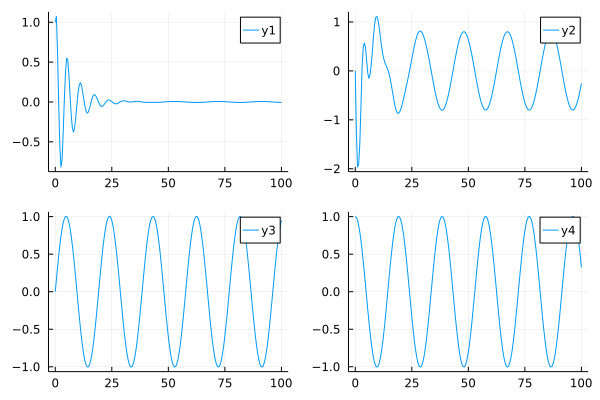

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [6]:
prob = ODEProblem(Duffing_change,initial,tspan,param)
sol = Array(solve(prob,Tsit5(),saveat=t_time))
plot(t_time,transpose(sol),layout = grid(2, 2))

In [7]:
sol

4×200 Matrix{Float64}:
 1.0   1.07391    0.608195  -0.0165678  -0.546526  …  -0.00563374  -0.0060497
 0.0  -1.27912   -1.96532   -1.90414    -1.48532      -0.37765     -0.257356
 0.0   0.16351    0.324351   0.477051    0.61622       0.884014     0.949747
 1.0   0.989256   0.950554   0.884607    0.794269      0.475549     0.32493

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpHS1M6IGZpbGUgb3BlbiBlcnJvciAoQzpcVXNlcnNc1tzM7LrjXC5qdWxpYVxhcnRpZmFjdHNcYzkzNTExNmM5YzdiOTFiNGYyN2JhMmIzYzlmN2M2YjYzOWIzMDJhY1xiaW5cLi5cRk9OVFNcR0tTRk9OVC5EQVQpCg==


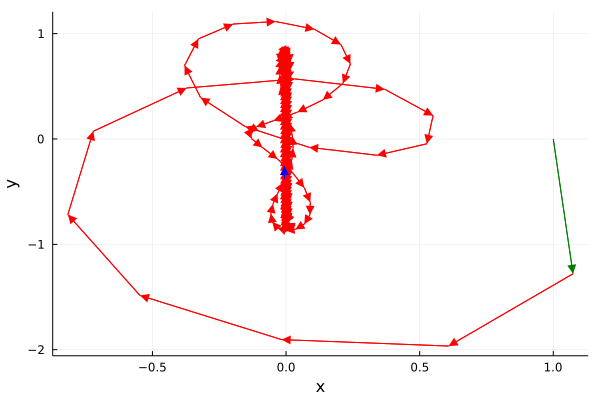

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpHS1M6IGZpbGUgb3BlbiBlcnJvciAoQzpcVXNlcnNc1tzM7LrjXC5qdWxpYVxhcnRpZmFjdHNcYzkzNTExNmM5YzdiOTFiNGYyN2JhMmIzYzlmN2M2YjYzOWIzMDJhY1xiaW5cLi5cRk9OVFNcR0tTRk9OVC5EQVQpCg==


In [8]:
GR.setarrowsize(1)
p = plot()
for i in 2:size(sol)[2]
    x = sol[1,i-1:i]
    y = sol[2,i-1:i]
    #println(pos1,pos2)
    if i != size(sol)[2] && i !=2
        plot!(x,y,arrow = :closed,label = "",color = "red")
    elseif i == 2
        plot!(x,y,arrow = :closed,label = "",color = "green")
    else
        plot!(x,y,arrow = :closed,label = "",color = "blue",xaxis = "x",yaxis = "y")
    end
end
display(p)

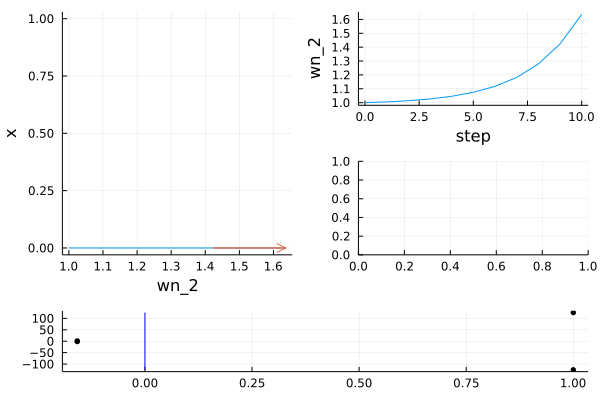

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


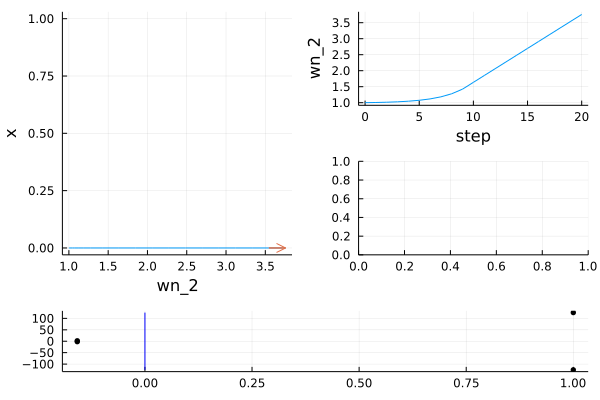

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


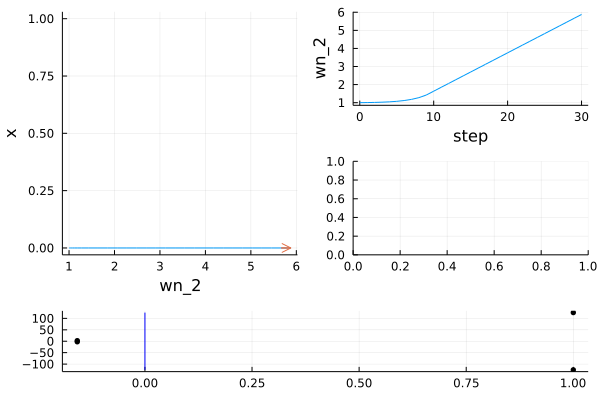

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


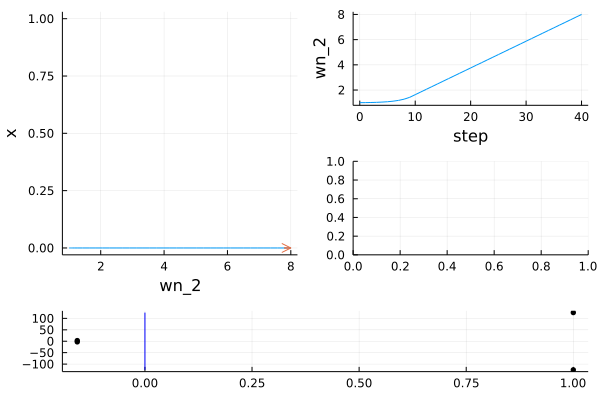

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


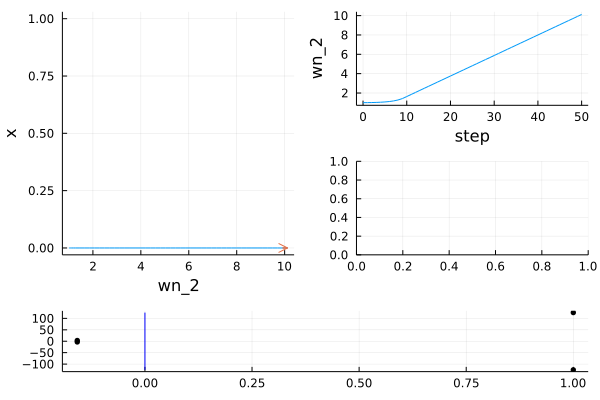

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


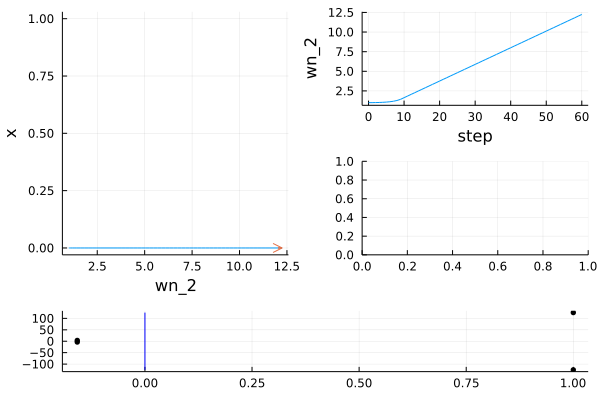

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


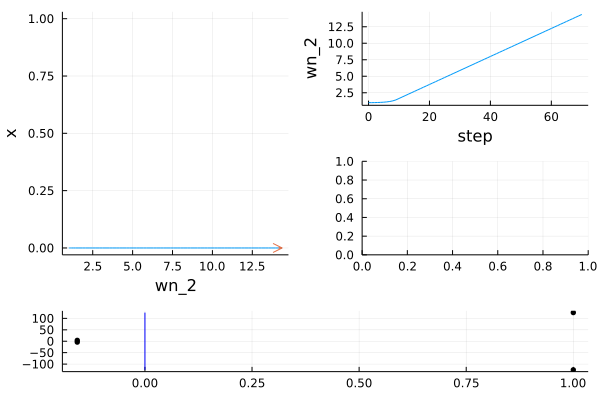

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


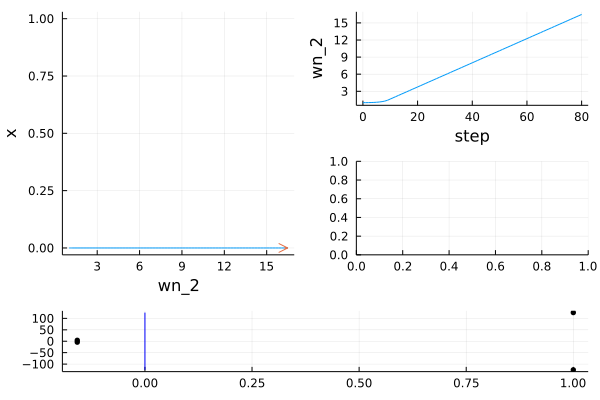

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


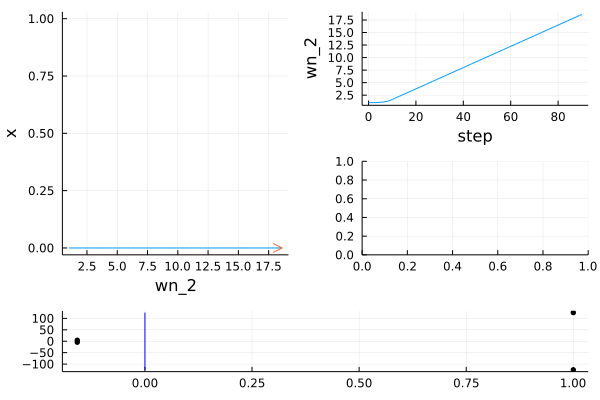

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


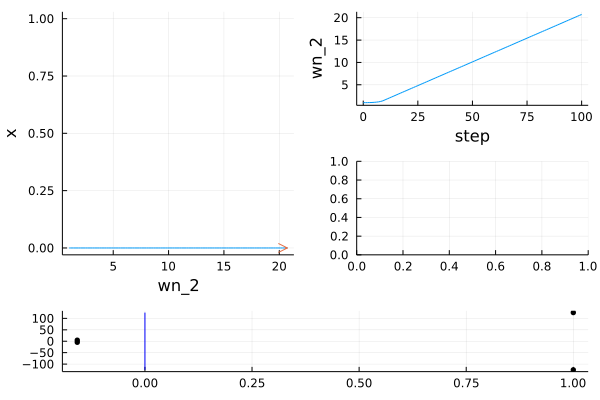

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


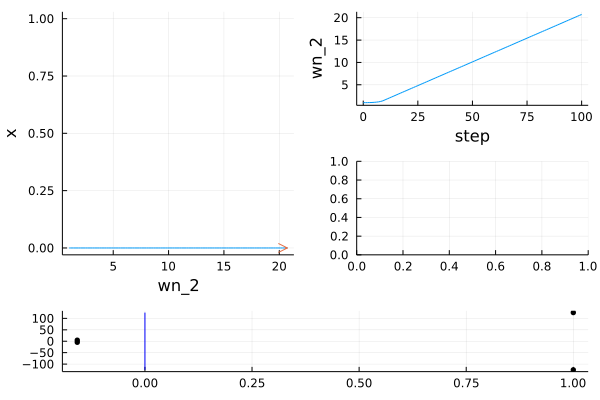

 39.868371 seconds (72.89 M allocations: 5.210 GiB, 3.87% gc time, 98.46% compilation time)


open: No such file or directory
open: No such file or directory
base64 binary data: R0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQpHS1M6IGZpbGUgb3BlbiBlcnJvciAoQzpcVXNlcnNc1tzM7LrjXC5qdWxpYVxhcnRpZmFjdHNcYzkzNTExNmM5YzdiOTFiNGYyN2JhMmIzYzlmN2M2YjYzOWIzMDJhY1xiaW5cLi5cRk9OVFNcR0tTRk9OVC5EQVQpCg==


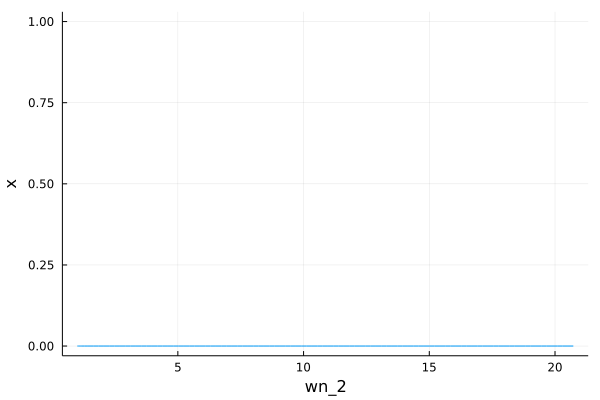

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [9]:
const BK = BifurcationKit
norminf(x) = norm(x, Inf)
parlor = (b = param[1],wn_2 = param[2],mu = param[3],v=param[4],rho=param[5],delta_st=param[6],w=param[7])
recordFromSolution(r, p) = (x = r[1], y = r[2],u1 = r[3],u2 = r[4])

prob = BifurcationProblem(Duffing_change, initial, parlor, (@lens _.wn_2);recordFromSolution)

opts_br = ContinuationPar(pMin = -10.0, pMax = 1000.0, ds = 0.004, dsmax = 0.15, nInversion = 8, 
    detectBifurcation = 3, maxBisectionSteps = 25, nev = 4)

#@set! opts_br.newtonOptions.verbose = false

br = @time continuation(prob, PALC(), opts_br;plot = true, normC = norminf)

scene = plot(br, plotfold=false, markersize=3, legend=:topleft)